In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/SDG/project/sdg-codebase

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SDG/project/sdg-codebase


# Loading data

In [ ]:
import pandas as pd
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AdamW
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
def read_data():
  return pd.read_csv("data/SDG_5Ps_rainmaking_impact_others_1_label.csv")

data = read_data()
data.shape

(2463, 12)

In [ ]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Company,Website,Source,Description,Location,SDG Goal,five Ps,Rainmaking SDG Subtopic,Impact Statement,Location of Impact
0,0,0,10Power,http://10pwr.com/,Rainmaking,10Power provides project development and finan...,USA,7,Prosperity,7.1 Energy Access Solutions,To provide project development and finance for...,United States of America
1,1,1,1Efficiency,1efficiency.com,Rainmaking,1Efficiency offers an integrated suite of cust...,USA,7,Prosperity,7.4 Energy Enablers,Energy management suite,United States of America
2,2,2,21CC Education,21cceducation.com,Rainmaking,21CC's offers courses for mid and higher level...,Netherlands,9,Prosperity,9.1 Innovative Logistics,21CC Recruitment & Training - Careers & Learni...,Netherlands/India/USA/Thailand
3,3,3,24SEA,24sea.eu,Rainmaking,24SEA provides a suite of solutions for monito...,Belgium,7,Prosperity,7.1 Energy Access Solutions,Offshore monitoring and engineering service pr...,Belgium
4,4,4,3B Ventures,https://3bvc.com,Rainmaking,3B Ventures is an early stage impact fund inve...,Malaysia,9,Prosperity,9.4 Data-based SME financing for developing ma...,Provider of AI consulting and data analytics s...,Denmark


In [ ]:
data['SDG Goal'].value_counts()

7     591
2     365
3     250
1     219
9     165
12    148
13    136
4      98
8      80
16     78
6      56
11     55
14     55
10     51
5      45
15     37
17     34
Name: SDG Goal, dtype: int64

In [ ]:
data['five Ps'].value_counts()

Prosperity      1090
People          1033
Planet           228
Peace             78
Partnerships      34
Name: five Ps, dtype: int64

In [ ]:
data['Location'].str.lower().value_counts()[:50]

usa               467
sweden            204
denmark           166
india             126
norway            114
united kingdom    111
finland            73
netherlands        63
københavn          57
kenya              48
france             42
germany            38
canada             35
spain              34
australia          31
israel             30
helsinki           30
south africa       29
switzerland        25
austria            24
mexico             24
china              20
argentina          19
chile              19
singapore          19
nigeria            16
ireland            15
italy              15
ghana              13
helsingfors        13
brazil             13
oslo               12
belgium             9
colombia            9
espoo               8
uganda              8
peru                8
stockholm           8
indonesia           8
thailand            7
copenhagen          6
philippines         6
frederiksberg       6
guatemala           6
oulu                6
odense    

# plot metrics

In [ ]:
def plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose=False):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  if verbose:
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

  return accuracy

In [ ]:
def plotConfusionMatrix(y_test, y_pred, labels):
  cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=labels, 
        yticklabels=labels, title="Confusion matrix")
  plt.yticks(rotation=0)

In [ ]:
def plotRocPrecRecallCurve(y_test, predicted_prob, labels):
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  ## Plot roc
  for i in range(len(labels)):
      fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                metrics.auc(fpr, tpr),)
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(labels)):
      precision, recall, thresholds = metrics.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                    metrics.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

In [ ]:
def SDGToFivePs(x):
  x = int(x.replace("_goal",""))
  if x in range(0,7):
    return 'People'
  if x in range(13,16):
    return 'Planet'
  if x in range(7,13):
    return 'Prosperity'
  if x in range(16,17):
    return 'Peace'
  if x in range(17,18):
    return 'Partnerships'
  return None

# Model

In [ ]:
class SDGModel(torch.nn.Module):
  def __init__(self, output_size):
    super(SDGModel, self).__init__()
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.bert = BertModel.from_pretrained('bert-base-uncased')
#     for index, param in enumerate(self.bert.parameters()):
#         print(index, param.shape)
#         param.requires_grad = False
    self.out1 = torch.nn.Linear(768, 400)
    self.drop = torch.nn.Dropout(0.5)
    self.out2 = torch.nn.Linear(400, output_size)

  def forward(self, text):
    tokenized_text = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens]).cuda()
    
    if tokens_tensor.shape[1] > 500:
      tokens_tensor = tokens_tensor[0][0:500].unsqueeze(0)
    outputs = self.bert(tokens_tensor)[0]
    o = torch.nn.ReLU()(self.out1(outputs[0][0]))
    o = self.drop(o)
    return self.out2(o)


In [ ]:
from sklearn import metrics
import seaborn as sns
import numpy as np

def evaluate_mode(X_test, model, verbose=True):

  model.eval()
  errors = []

  #eval
  with torch.no_grad():
      y_pred = []
      predicted_prob = []
      y_test = X_test["Target"]
      for index, instance in X_test.iterrows():
          out = model(instance["Description"].lower())
          norm = abs(min(out))+out
          probs = [x/sum(norm).item() for x in norm.tolist()]
          predicted_prob.append(probs)
          y_pred.append(labels[torch.argmax(out).item()])
          # collect companies with errors
          if instance['Target'] != labels[torch.argmax(out).item()]:
            errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
      model.train()

  predicted_prob = np.array(predicted_prob)

  ## plot Accuracy, Precision, Recall
  accuracy = plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose)
      
  ## Plot confusion matrix
  plotConfusionMatrix(y_test, y_pred, labels)

  ## Plot roc, precision recall curve
  if verbose:
    plotRocPrecRecallCurve(y_test, predicted_prob, labels)

  return errors[:5], accuracy

In [ ]:
# def evaluate_mode(test_data, model):
#     model.eval()
#     errors = []
#     with torch.no_grad():
#         y_pred = []
#         y_test = test_data["Target"]
#         for index, instance in test_data.iterrows():
#             out = model(instance["Description"].lower())
#             y_pred.append(labels[torch.argmax(out).item()])
#             # collect companies with errors
#             if instance['Target'] != labels[torch.argmax(out).item()]:
#               errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
#         model.train()
#         return confusion_matrix(y_test, y_pred, labels=labels), accuracy_score(y_test, y_pred), errors


# All Goals

##Predict Five Ps from all goals

In [ ]:
data = read_data()
data.shape

(2463, 12)

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

['Prosperity', 'People', 'Planet', 'Peace', 'Partnerships']
2093 2093
370 370
Int64Index([157, 1395, 1983, 498, 765], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

Prosperity      925
People          884
Planet          189
Peace            64
Partnerships     31
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

Prosperity      165
People          149
Planet           39
Peace            14
Partnerships      3
Name: Target, dtype: int64

In [ ]:
model = SDGModel(len(labels)).cuda()
# model = torch.load("models/allGoalsTo5Ps3.net")

In [ ]:
model("Hello World")
# model.train()

tensor([ 0.0741, -0.0099, -0.1677,  0.1670, -0.0598], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

2093
Epoch=1, index=540, loss=0.3426271637280782
People --> Prosperity
Epoch=1, index=270, loss=1.1573862910270691
People --> Prosperity
Epoch=1, index=1020, loss=3.0269584248463315
People --> Prosperity
Epoch=1, index=2460, loss=2.4178476770718893
Prosperity --> Prosperity
Epoch=1, index=1590, loss=3.092602460583051
Prosperity --> People
Epoch=1, index=1890, loss=0.3340208888053894
People --> People
Epoch=1, index=840, loss=1.153268936276436
People --> People
Epoch=1, index=120, loss=0.18614516258239747
Prosperity --> Prosperity
Epoch=1, index=960, loss=0.03394990166028341
Prosperity --> Prosperity
Epoch=1, index=780, loss=1.0901807362834612
Prosperity --> People
Epoch=1, index=1380, loss=1.4710604300101597
People --> People
Epoch=1, index=300, loss=0.45847005595763524
Prosperity --> Prosperity
Epoch=1, index=600, loss=0.9820684383312861
Prosperity --> Prosperity
Epoch=1, index=2340, loss=0.7825557318826516
Prosperity --> Prosperity
Epoch=1, index=2160, loss=0.5590905946989854
People 

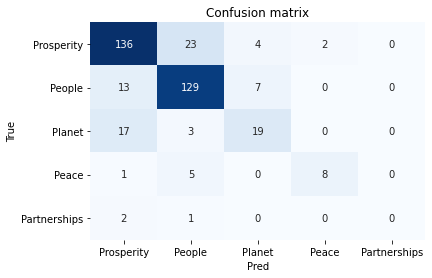

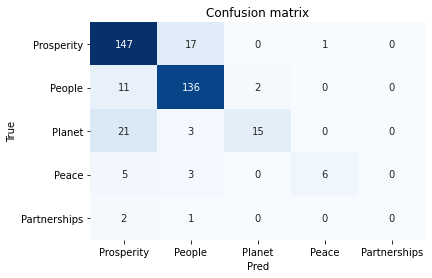

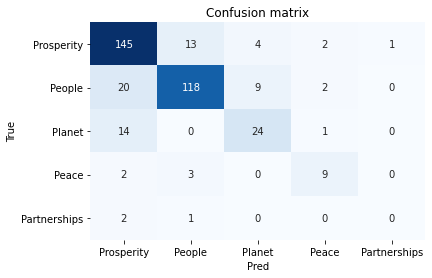

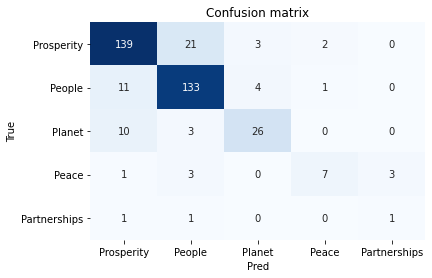

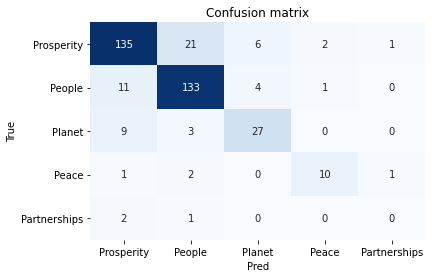

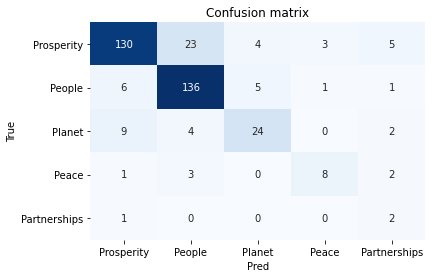

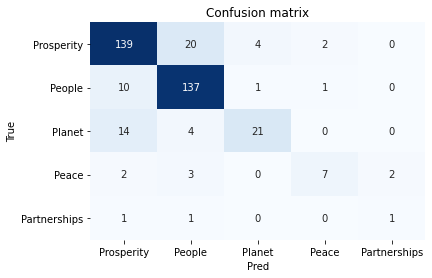

In [ ]:
import time

n_epochs = 7

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model, False)
  print(error)
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.82
Auc: 0.51
Detail:
              precision    recall  f1-score   support

Partnerships       0.33      0.33      0.33         3
       Peace       0.70      0.50      0.58        14
      People       0.83      0.92      0.87       149
      Planet       0.81      0.54      0.65        39
  Prosperity       0.84      0.84      0.84       165

    accuracy                           0.82       370
   macro avg       0.70      0.63      0.66       370
weighted avg       0.82      0.82      0.82       370



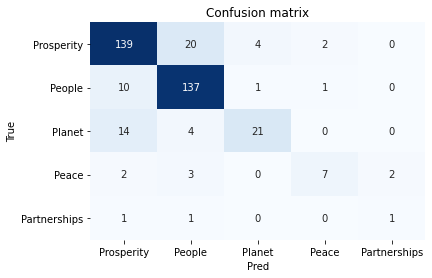

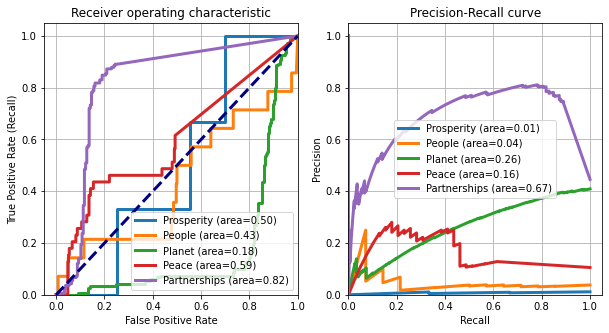

([('Parkkisähkö', 'Prosperity', 'Planet'),
  ('Rel8', 'Planet', 'Prosperity'),
  ('Nocofio', 'Prosperity', 'People'),
  ('Sawtooth seafood', 'Planet', 'People'),
  ('Deedster', 'Prosperity', 'Peace')],
 0.8243243243243243)

In [ ]:
evaluate_mode(X_test, model)

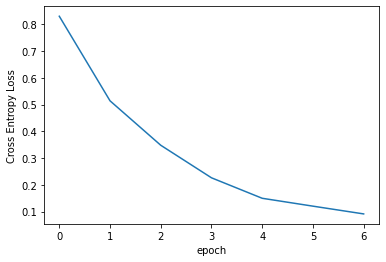

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
# errors

In [ ]:
scores = [x[1] for x in errors]
print(f"avg - {sum(scores[-10:])/len(scores[-10:])}")
scores

avg - 0.813899613899614


[0.7891891891891892,
 0.8216216216216217,
 0.8,
 0.827027027027027,
 0.8243243243243243,
 0.8108108108108109,
 0.8243243243243243]

In [ ]:
# Be careful to overwrite our original name file!
model_name = 'models/allGoalsTo5Ps3.net'

In [ ]:
torch.save(model,model_name)

In [ ]:
# model = torch.load(model_name)
# model.eval()

##Predict Goals from all goals

In [ ]:
data = read_data()
data.shape

(2463, 12)

In [ ]:
data['Target'] = data['SDG Goal']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

[7, 2, 3, 1, 9, 12, 13, 4, 8, 16, 6, 11, 14, 10, 5, 15, 17]
2093 2093
370 370
Int64Index([157, 1395, 1983, 498, 765], dtype='int64')


In [ ]:
X_test['Target'].value_counts()

7     86
2     61
3     33
1     31
9     30
12    28
13    21
14    15
16    14
4     12
8     10
6      8
11     6
10     5
5      4
15     3
17     3
Name: Target, dtype: int64

In [ ]:
model = SDGModel(len(labels)).cuda()
# model = torch.load("models/allGoalsToGoals3.net")

In [ ]:
model("Hello World")

tensor([-0.3116,  0.1905, -0.1943, -0.1998, -0.3223,  0.0833, -0.1255, -0.2417,
        -0.0740,  0.0847,  0.1603, -0.2312, -0.1569,  0.2418, -0.1918, -0.2143,
         0.2873], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

2093
Epoch=1, index=2280, loss=1.1508437156677247
8 --> 6
Epoch=1, index=1920, loss=7.443877434730529
2 --> 2
Epoch=1, index=1590, loss=5.106106702486674
8 --> 7
Epoch=1, index=600, loss=1.0040834108988443
7 --> 7
Epoch=1, index=2130, loss=3.6928747495015464
5 --> 7
Epoch=1, index=840, loss=9.372736271222433
2 --> 2
Epoch=1, index=1020, loss=2.4897794564565023
2 --> 2
Epoch=1, index=1620, loss=1.274224179983139
9 --> 7
Epoch=1, index=570, loss=2.5063870122035343
2 --> 2
Epoch=1, index=1680, loss=0.5682085355122884
7 --> 7
Epoch=1, index=330, loss=0.9362632433573405
7 --> 7
Epoch=1, index=300, loss=1.4165946225325265
12 --> 2
Epoch=1, index=1410, loss=3.908199120561282
7 --> 7
Epoch=1, index=1290, loss=2.619175292054812
5 --> 3
Epoch=1, index=390, loss=0.7074790149927139
16 --> 1
Epoch=1, index=2160, loss=6.520841281612714
3 --> 3
Epoch=1, index=2190, loss=1.4361443102359772
4 --> 3
Epoch=1, index=750, loss=1.048728131254514
2 --> 7
Epoch=1, index=1740, loss=2.7084211806456246
3 --> 8
E

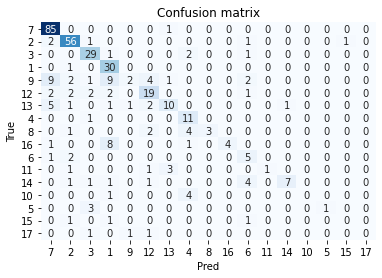

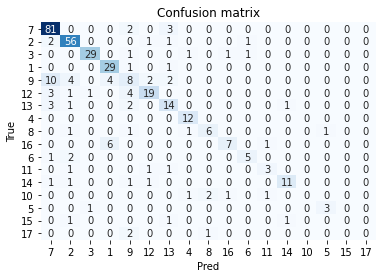

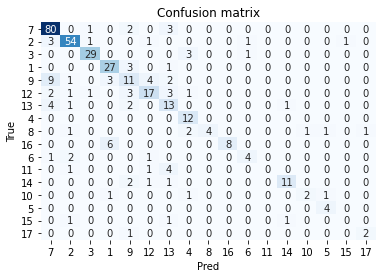

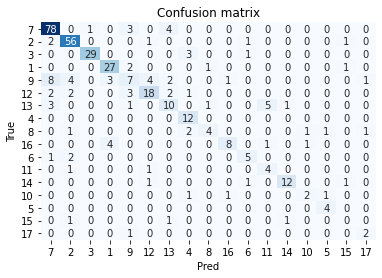

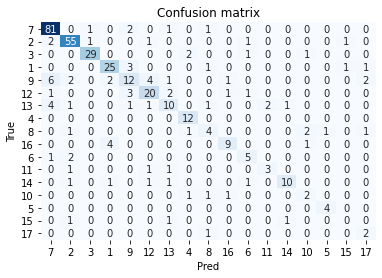

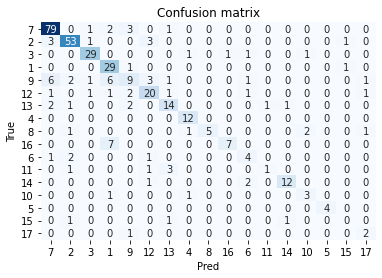

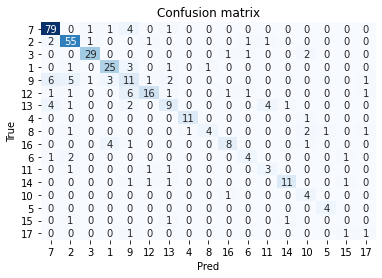

In [ ]:
import time

n_epochs = 7

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model, False)
  print(error)
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

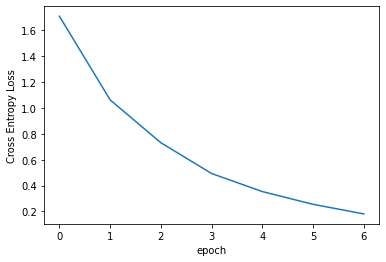

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

Accuracy: 0.74
Auc: 0.59
Detail:
              precision    recall  f1-score   support

           1       0.70      0.74      0.72        31
           2       0.81      0.90      0.85        61
           3       0.93      0.79      0.85        33
           4       0.73      0.92      0.81        12
           5       0.80      1.00      0.89         4
           6       0.50      0.38      0.43         8
           7       0.84      0.94      0.89        86
           8       0.71      0.50      0.59        10
           9       0.50      0.37      0.42        30
          10       0.20      0.20      0.20         5
          11       0.50      0.33      0.40         6
          12       0.69      0.64      0.67        28
          13       0.50      0.57      0.53        21
          14       0.87      0.87      0.87        15
          15       0.00      0.00      0.00         3
          16       0.80      0.57      0.67        14
          17       0.50      0.67      0.57     

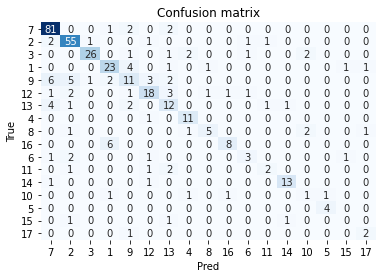

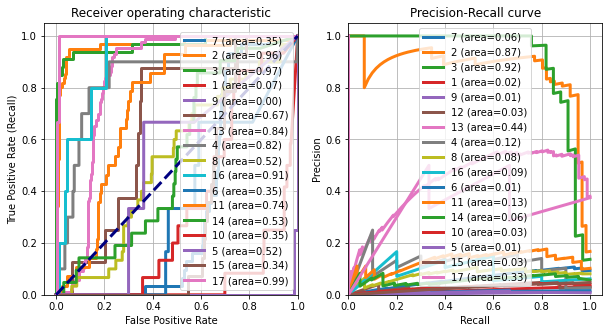

([('Parkkisähkö', 7, 13),
  ('Rel8', 13, 9),
  ('Nocofio', 8, 2),
  ('DoPay', 1, 8),
  ('MEMBRASENZ GmbH', 7, 9)],
 0.7432432432432432)

In [ ]:
evaluate_mode(X_test, model)

In [ ]:
# errors

In [ ]:
scores = [x[1] for x in errors]
print(f"avg - {sum(scores[-10:])/len(scores[-10:])}")
scores

avg - 0.7498069498069497


[0.7108108108108108,
 0.7648648648648648,
 0.7513513513513513,
 0.7513513513513513,
 0.7648648648648648,
 0.7648648648648648,
 0.7405405405405405]

In [ ]:
# Be careful to overwrite our original name file!
model_name = 'models/allGoalsToGoals3.net'

In [ ]:
torch.save(model,model_name)

# Top N Goals

In [ ]:
# Configuration

N = 7
n_epochs = 30

def readDataAndselectTopGoals(N):
  data = read_data()
  labels = data['SDG Goal'].value_counts().index.tolist()[:N]
  return data[data['SDG Goal'].isin(labels)]


##Predict Five Ps from Top N goals

In [ ]:
data = readDataAndselectTopGoals(N)
data.shape

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

In [ ]:
data['Target'].value_counts()

Prosperity    292
People        285
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

In [ ]:
model = SDGModel(len(labels)).cuda()

In [ ]:
model("Hello World")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["About"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss}")
  losses.append(curr_loss)
  errors.append(error)
  if e%5 == 0:
    print(f"TIME TILL NOW: for {e} epochs - {(time.time() - start_time)/60:.1f} min")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
evaluate_mode(X_test, model)

In [ ]:
errors

In [ ]:
scores = [x[1] for x in errors]
scores

##Predict Goals from Top N goals

In [ ]:
data = readDataAndselectTopGoals(N)
data.shape

In [ ]:
data['Target'] = data['SDG Goal']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

In [ ]:
X_test['Target'].value_counts()

In [ ]:
model = SDGModel(len(labels)).cuda()

In [ ]:
model("Hello World")

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import time

start_time = time.time()
losses = []
errors = []

for e in range(1, n_epochs+1):
  current_loss = 0
  curr_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    optimizer.zero_grad()
    out = model(instance["About"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    curr_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error = evaluate_mode(X_test, model)
  print(error)
  print(f"total loss={curr_loss}")
  losses.append(curr_loss)
  errors.append(error)
  if e%5 == 0:
    print(f"TIME TILL NOW: for {e} epochs - {(time.time() - start_time)/60:.1f} min")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(n_epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
evaluate_mode(X_test, model)

In [ ]:
errors

In [ ]:
scores = [x[1] for x in errors]
scores